In [1]:
from tensorflow import keras
from tensorflow.keras import layers

functional api는 sequential 모델처럼 하나의 입력과 출력을 가지는 예시는 물론,   
sequential에서 다룰 수 없는 다중 입력 형태와 출력을 다룰 수 있다.
sequential처럼 하나의 입력과 출력을 가지는 예시를 functional api로 구현할 경우 다음과 같이 할 수 있다.

### 단일 입력, 단일 출력 functional api model

In [2]:
inputs = keras.Input(shape=(3, ), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

**과정**
1) Input 클래스 객체를 정의(이름을 지정할 수 있음)  
```inputs = keras.Input(shape=(3,), name="my_input")```  
인풋 객체는 모델이 처리할 데이터의 크기와 dtype에 대한 정보를 가진다. 이러한 객체를 심볼릭 텐서(symbolic tensor)라고 부른다.  
(실제 데이터를 가지지 않았고, 사용할 때 모델이 보게 될 데이터 텐서의 사양에 대한 정보만 가지고 있다. 미래의 데이터 텐서를 나타낸다.)

In [3]:
inputs.shape

TensorShape([None, 3])

2) 층을 만들고 이 입력으로 호출  
모든 케라스 층은 실제 데이터 텐서나 심볼릭 텐서로 호출 가능하다.   
후자의 경우(층을 거쳐) 크기와 dtype 정보가 업데이트된 새로운 심볼릭 텐서가 반환된다.

In [4]:
features = layers.Dense(64, activation="relu")(inputs)

In [5]:
features.shape

TensorShape([None, 64])

3) 최종 출력을 얻은 후 입력과 출력을 Model 클래스에 전달하여 모델 객체를 생성  

In [6]:
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 다중 입력, 다중 출력 모델
간단한 모델과 달리 대부분 딥러닝 모델은 다중 입력, 다중 출력을 가진다.
입력이 여러 개이거나 출력이 여러 개인 경우를 다루는 모델을 구현할 때 함수형 API가 사용된다.

예시  
고객 이슈 티켓에 우선순위를 지정하고 적절한 부서로 전달하는 시스템  
이 시스템은 3개의 입력을 사용함  
- 이슈 티켓의 제목(텍스트 입력)  
- 이슈 티켓의 텍스트 본문(텍스트 입력)  
- 사용자가 추가한 태그(범주형 입력으로 여기에서는 원-핫 인코딩되었다고 가정)  
텍스트 입력은 크기가 vocabulary_size인 0과 1로 이루어진 배열로 인코딩할 수 있음  


이 시스템의 출력도 다중(2가지) 출력임  
- 이슈 티켓의 우선순위 점수로 0과 1 사이의 스칼라(시그모이드 출력)  
- 이슈 티켓을 처리해야 할 부서(전체 부서 집합에 대한 소프트맥스 출력)  

코드:

In [8]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

# 모델 입력을 하나의 텐서 feature로 연결
features = layers.Concatenate()([title, text_body, tags])

# 중간층
features = layers.Dense(64, activation="relu")(features)

# 모델의 출력은 다음과 같이 각각 다른 층을 거쳐 얻음
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
                              num_departments,
                              activation="softmax",
                              name="department"
                         )(features)

# 모델의 입력과 출력을 지정하여 모델을 만듬
model = keras.Model(inputs=[title, text_body, tags],
                   outputs=[priority, department])

### 다중 입력, 다중 출력 모델 훈련하기  
Sequential 모델을 훈련하는 것과 거의 같은 방법으로 이 모델을 훈련함  
입력과 출력 데이터의 리스트로 fit()메서드를 호출하면 되며,  
데이터의 리스트는 Model 클래스에 전달한 순서와 같아야 함

In [9]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(
                 optimizer="rmsprop",
                 loss=["mean_squared_error", "categorical_crossentropy"],
                 metrics=[["mean_absolute_error"], ["accuracy"]]
             )

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict(
[title_data, text_body_data, tags_data]
)

40/40 [==============================] - 0s 7ms/step - loss: 19.0358 - priority_loss: 0.3322 - department_loss: 18.7036 - priority_mean_absolute_error: 0.4955 - department_accuracy: 0.2672


이 때 입력을 순서에 상관없이 줄 수 있는데 Input 객체와 출력 층에 부여한 이름을 활용해 데이터를 딕셔너리로 전달할 수 있다.  
Input 객체와 출력 층에 부여한 이름:  
```
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers(Concatenate()([title, text_body, tags])

...

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
                           num_departments, activation="softmax", name="department"
                         )(features)
```

In [10]:
model.compile(optimizer="rmsprop",
             loss={"priority":"mean_squared_error", "department":
                  "categorical_crossentropy"},
             metrics={"priority":["mean_absolute_error"],
                     "department":["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
         {"priority": priority_data, "department": department_data},
         epochs=2)
model.evaluate({"title": title_data, "text_body": text_body_data,
               "tags": tags_data},
              {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
{"title": title_data, "text_body": text_body_data, "tags": tags_data})

Epoch 1/2
40/40 [==============================] - 2s 23ms/step - loss: 31.0216 - priority_loss: 0.3322 - department_loss: 30.6894 - priority_mean_absolute_error: 0.4955 - department_accuracy: 0.2531
Epoch 2/2
40/40 [==============================] - 0s 8ms/step - loss: 44.9665 - priority_loss: 0.3322 - department_loss: 44.6344 - priority_mean_absolute_error: 0.4955 - department_accuracy: 0.2672


### 모델 시각화와 특성 추출:
이렇게 했을 때의 장점은 모델의 그래프 데이터 구조를 명시적으로 정의했기 때문에  
층의 연결을 조사하고 이전 그래프 노드(층의 출력)을 새 모델의 일부로 재사용할 수 있다는 점이다.  


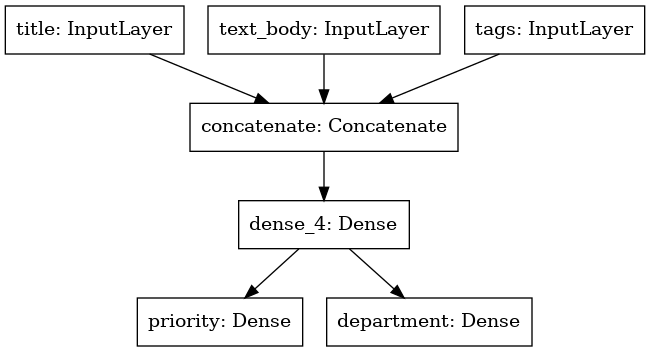

In [11]:
# plot_model() : 함수영 모델을 그래프로 그림
keras.utils.plot_model(model, "ticket_classifier.png")

모델의 각 층의 입출력 크기를 그림에 추가할 수 있다.

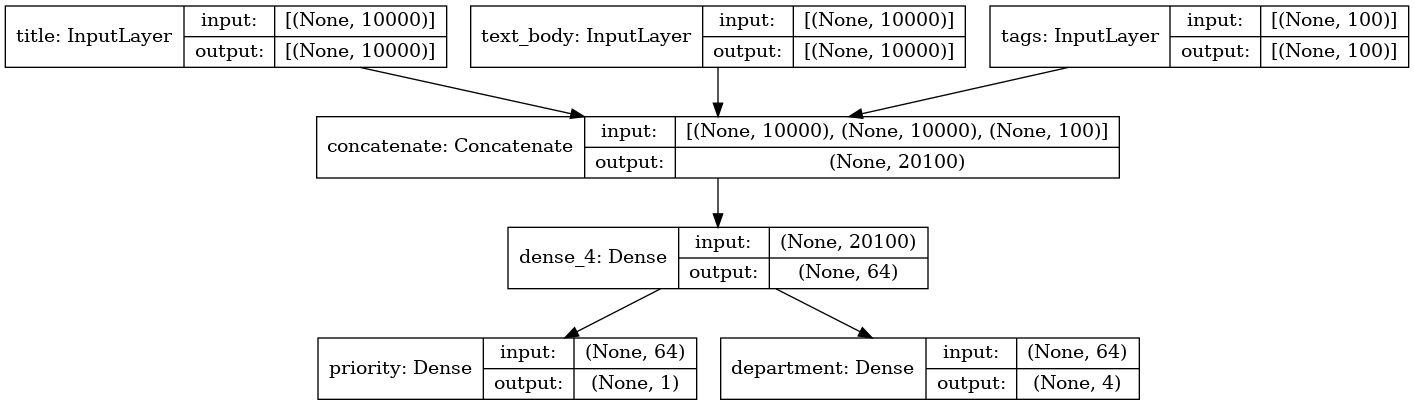

In [12]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

층 연결 구조를 참조하여 그래프에 있는 개별 노드를 조사하고 재사용(층 호출)할 수 있다.

In [13]:
# model.layers 속성: 모델에 있는 모든 층의 리스트를 가지고 있으며, 각 층에 대해 layer.input과 layer.output을 출력해 볼 수 있음
model.layers 


In [14]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [15]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

이를 통해 특성 추출을 수행하여 다른 모델에서 중간 특성을 재사용하는 모델을 만들 수 있다.  
예컨대 이전 모델에 또 다른 출력을 추가한다고 가정하였다.
- 이슈 티켓이 해결되는 데 걸리는 시간(즉 난이도) 를 추정하려고 한다.
- 이를 위해 "quick", "medium", "difficult" 세 개의 범주에 대한 분류 층을 추가한다.

모델을 처음부터 다시 만들고 재훈련할 필요가 없이 다음과 같이 중간층을 참조하여 이전 모델의 중간 특성에서 시작할 수 있다.

In [17]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)
new_model = keras.Model(
                            inputs=[title, text_body, tags],
                            outputs=[priority, department, difficulty]
                        )


새로운 모델을 그래프로 출력하였다.

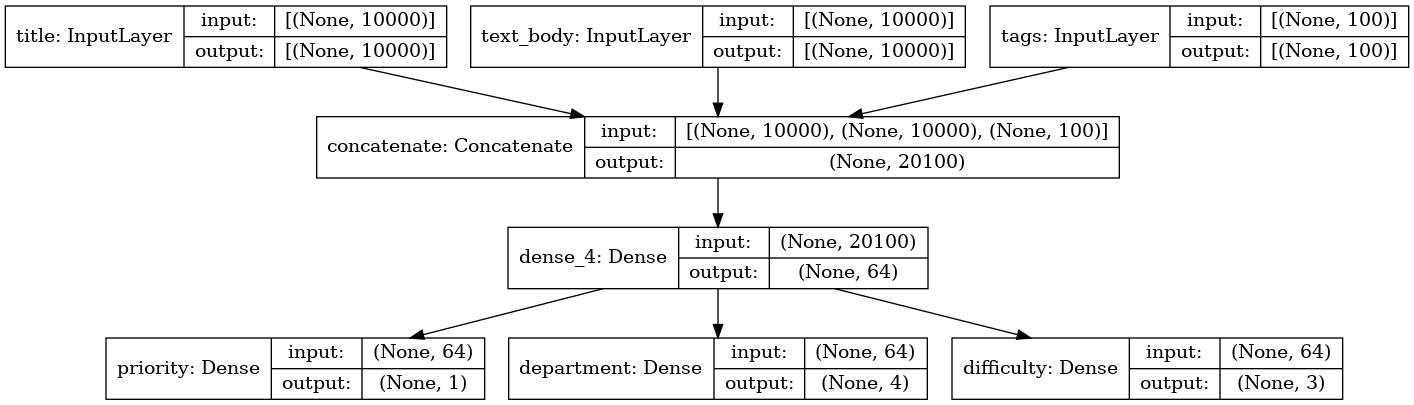

In [18]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)